#### Example of text classification with doc2vec embeddings generated from the target corpus (Consumer Finance Complaints dataset).

Reference pages:
- https://radimrehurek.com/gensim/auto_examples/tutorials/run_doc2vec_lee.html#sphx-glr-auto-examples-tutorials-run-doc2vec-lee-py

The dataset was preprocessed in **finance complaints dataset analysis** notebook.

Loading balanced dataset.

In [1]:
import pandas as pd
df = pd.read_csv('complaints-balanced.csv')
df.head()

,Unnamed: 0,Product,Consumer_complaint_narrative,category_id
0,0,"Credit reporting, credit repair services, or o...",These aren't mine ... please remove it.,0
1,1,"Credit reporting, credit repair services, or o...",XXXX and Transunion are incorrectly reporting ...,0
2,2,"Credit reporting, credit repair services, or o...",I have been disputing a derogatory mark on my ...,0
3,3,"Credit reporting, credit repair services, or o...",I have sent 3 letters to all 3 credit bureau '...,0
4,4,"Credit reporting, credit repair services, or o...",ive been working back and forth calling emaili...,0


In [2]:
print(df.isnull().sum())

Unnamed: 0                      0
Product                         0
Consumer_complaint_narrative    0
category_id                     0
dtype: int64


Text preprocessing

In [20]:
%%time
import re
import gensim

text = df.Consumer_complaint_narrative
# removing numbers
text = text.apply(lambda x: re.sub(r'\d+', '', x))

# removing XXX words
text = text.apply(lambda x: re.sub(r'X*', '', x))

# tokenizing, removing punctuation and converting to lower case
def pre_process(doc):
    return gensim.utils.simple_preprocess(doc)

text = text.apply(lambda x: pre_process(x))

text.head()

CPU times: user 2.43 s, sys: 5.79 ms, total: 2.44 s
Wall time: 2.44 s


0              [these, aren, mine, please, remove, it]
1    [and, transunion, are, incorrectly, reporting,...
2    [have, been, disputing, derogatory, mark, on, ...
3    [have, sent, letters, to, all, credit, bureau,...
4    [ive, been, working, back, and, forth, calling...
Name: Consumer_complaint_narrative, dtype: object

Creating train and test sets, with balanced frequency of classes.

In [92]:
from sklearn.model_selection import StratifiedShuffleSplit

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=0)
for train_index, test_index in sss.split(text, df['category_id']):
    train_set = text.loc[train_index]
    train_labels = df['category_id'].loc[train_index]
    test_set = text.loc[test_index]
    test_labels = df['category_id'].loc[test_index]

Creating document embeddings.

Doc2vec parameters:
- `size=n` - The dimension of the generated embedding vectors.
- `min_count=n` - Include the word in our vocabulary after n encounters.
- `iter=n` - In how many epochs should the Word2Vec model learn the semantic correlations.

In [93]:
%%time

def build_doc_model_inputs(docs):
    for i, doc in enumerate(docs):
        # Doc2Vec requires an index for each document
        yield gensim.models.doc2vec.TaggedDocument(doc, [i])

X_train_doc_model = list(build_doc_model_inputs(train_set))

CPU times: user 4.72 ms, sys: 16 µs, total: 4.74 ms
Wall time: 6.11 ms


In [108]:
%%time

doc_model = gensim.models.Doc2Vec(vector_size=300, min_count=5, dm=1, epochs=15)
doc_model.build_vocab(X_train_doc_model)
doc_model.train(X_train_doc_model, total_examples=doc_model.corpus_count, epochs=doc_model.epochs)

CPU times: user 33.7 s, sys: 627 ms, total: 34.3 s
Wall time: 14.9 s


Converting documents to vectors.

In [109]:
%%time
import numpy as np

def build_doc_vecs(model, docs):
    return np.vstack([model.infer_vector(doc) for doc in docs ])

X_train = build_doc_vecs(doc_model, train_set)
X_test = build_doc_vecs(doc_model, test_set)

CPU times: user 26.9 s, sys: 167 ms, total: 27 s
Wall time: 27 s


Let's train and evaluate some classifiers.

In [110]:
%%time
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn import svm
from sklearn.neural_network import MLPClassifier

models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LogisticRegression(solver='lbfgs', multi_class='auto', max_iter=1000, random_state=0),
    svm.LinearSVC(max_iter=10000, random_state=0),
    MLPClassifier(max_iter=1000, random_state=0)
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, X_train, train_labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

CPU times: user 4min 28s, sys: 1.7 s, total: 4min 30s
Wall time: 3min 24s


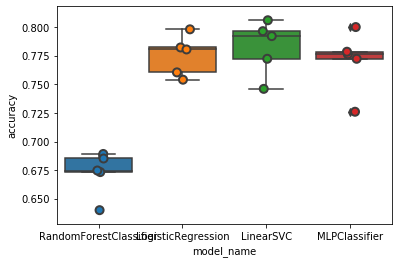

model_name
LinearSVC                 0.782541
LogisticRegression        0.775007
MLPClassifier             0.770592
RandomForestClassifier    0.672435
Name: accuracy, dtype: float64

In [111]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

cv_df.groupby('model_name').accuracy.mean()

Best model evaluation

In [112]:
from sklearn.metrics import accuracy_score, confusion_matrix

my_tags = df.category_id.unique()
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(my_tags))
    target_names = my_tags
    plt.xticks(tick_marks, target_names, rotation=45)
    plt.yticks(tick_marks, target_names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def evaluate_prediction(predictions, target, title="Confusion matrix"):
    print('accuracy %s' % accuracy_score(target, predictions))
    cm = confusion_matrix(target, predictions, labels=my_tags)
    print('confusion matrix\n %s' % cm)
    print('(row=expected, col=predicted)')
    
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plot_confusion_matrix(cm_normalized, title + ' Normalized')

accuracy 0.768303985171455
confusion matrix
 [[167  16  20   9   4]
 [ 37 141  17   9  12]
 [ 21  11 155   3  25]
 [ 10   2   5 192   7]
 [ 14   2  20   6 174]]
(row=expected, col=predicted)
CPU times: user 38.9 s, sys: 102 ms, total: 39 s
Wall time: 38.9 s


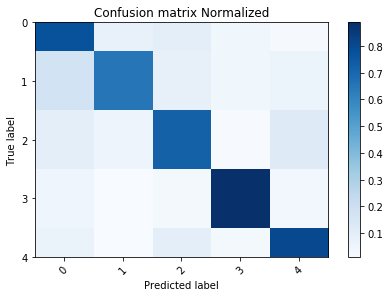

In [114]:
%%time
model = models[2]
model.fit(X_train, train_labels)
predicted = model.predict(X_test)
evaluate_prediction(predicted, test_labels)